In [1]:
import glob

import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.ndimage import zoom, distance_transform_edt, generic_filter, median_filter
import cmocean.cm as cm

%matplotlib inline

In [2]:
def fill_gaps_nn(array, distance=2, mask=None):
    """ Fill gaps in input array
    # https://stackoverflow.com/questions/5551286/filling-gaps-in-a-numpy-array/9262129#9262129
    Parameters
    ----------
    array : 2D numpy.array
        Raster with data
    distance : int
        Minimum size of gap to fill
    mask : 2D numpy.array
        Raster with True where to fill gaps
    Returns
    -------
    array : 2D numpy.array
        Raster with data with gaps filled
    """
    if mask is None:
        mask = np.isnan(array)
    dist, indi = distance_transform_edt(mask, return_distances=True, return_indices=True)
    gpi = dist <= distance
    r, c = indi[:, gpi]
    array = np.array(array)
    array[gpi] = array[r, c]
    return array

In [3]:
sic_dir = '/Data/sim/data/OSISAF_ice_conc_CDR/'
sid_dir = '/Data/sim/data/OSISAF_ice_drift_CDR_v1pre_multi_oi/'

In [14]:
year = '1991'
mo = '03'
sic_files = sorted(glob.glob(f'{sic_dir}/{year}/{mo}/*nc')) [:3]
sic_dates = [f.split('_')[-1].split('.')[0] for f in sic_files]
sid_files = [f for f in sorted(glob.glob(f'{sid_dir}/{year}/{mo}/*/*nc')) if f.split('-')[-1].split('.')[0] in sic_dates]

In [15]:
flag_values = np.array([ 0,  1,  2,  3,  4,  5, 10, 11, 12, 13, 20, 21, 22, 23, 30])
flag_conv = np.zeros(31)
flag_conv[flag_values] = np.arange(flag_values.size)


/Data/sim/data/OSISAF_ice_conc_CDR//1991/03/ice_conc_nh_ease2-250_cdr-v2p0_199103011200.nc


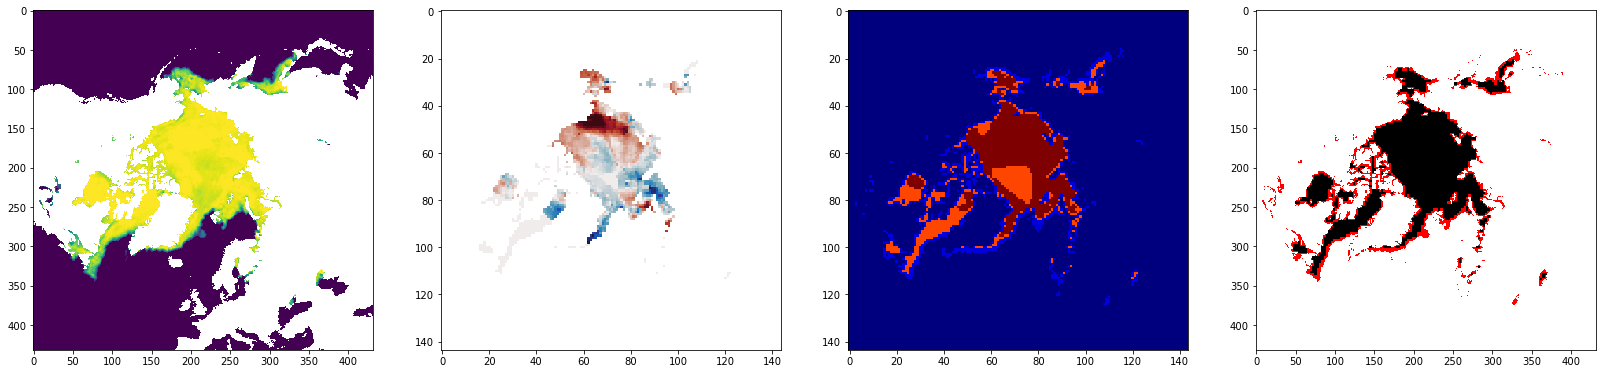

/Data/sim/data/OSISAF_ice_conc_CDR//1991/03/ice_conc_nh_ease2-250_cdr-v2p0_199103021200.nc


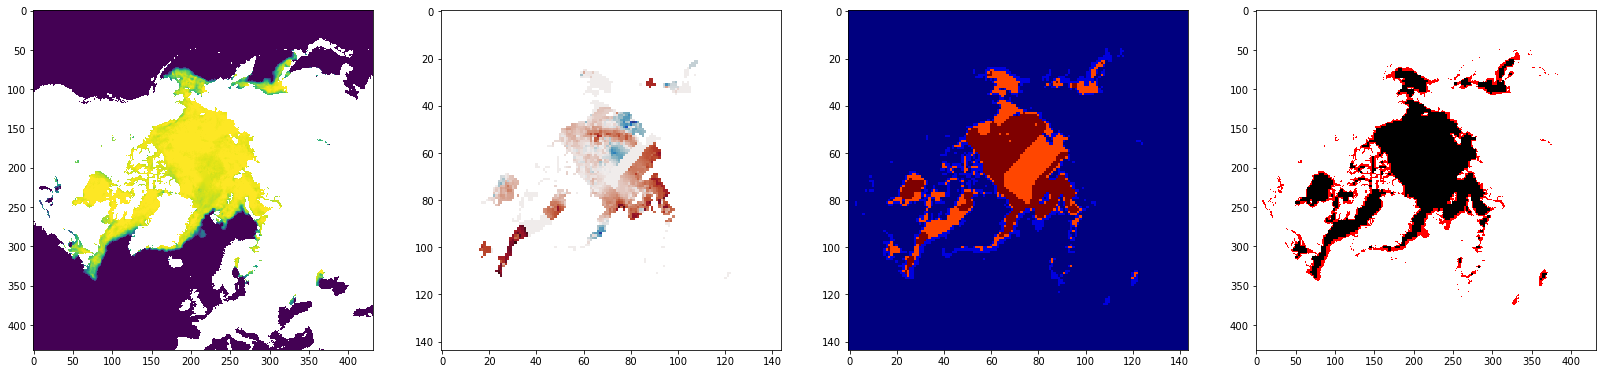

/Data/sim/data/OSISAF_ice_conc_CDR//1991/03/ice_conc_nh_ease2-250_cdr-v2p0_199103031200.nc


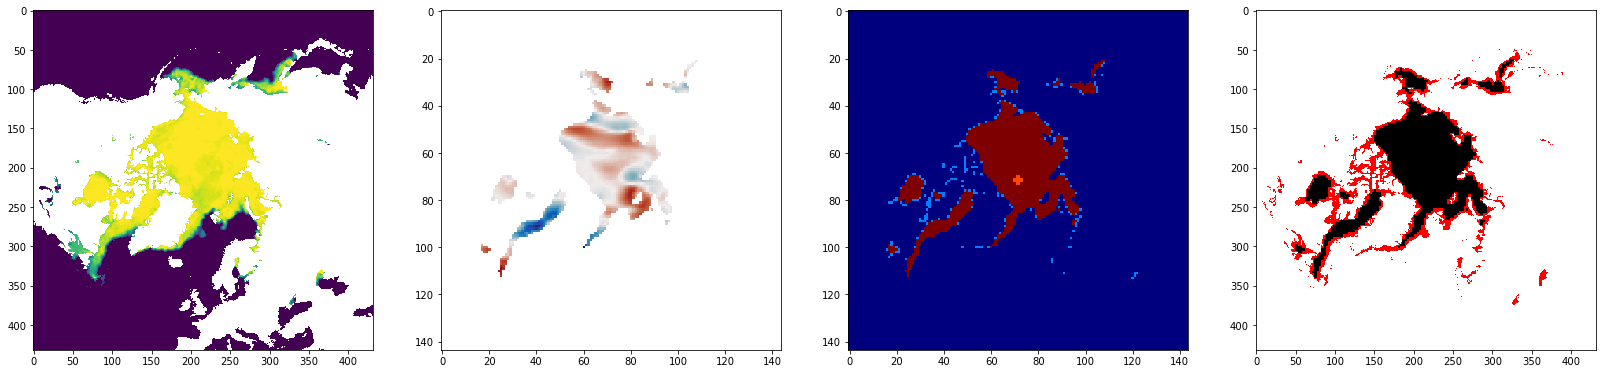

In [16]:
ddx = []
ddy = []

for sic_file, sid_file in zip(sic_files, sid_files):
    print(sic_file)
    cds = Dataset(sic_file)
    dds = Dataset(sid_file)
    sic = cds['ice_conc'][0].filled(np.nan)
    dx = dds['dX'][0].filled(np.nan)
    dy = dds['dY'][0].filled(np.nan)
    dflag = dds['status_flag'][0]
    
    ddx.append(dx)
    ddy.append(dy)

    fig, ax = plt.subplots(1,4, figsize=(28,7))
    ax[0].imshow(sic, interpolation='nearest')
    ax[1].imshow(dx, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)

    sic_mask = (sic > 0).astype(float)
    sic_mask[sic_mask == 0] = np.nan

    ax[2].imshow(flag_conv[dflag], clim=[2, 14], cmap='jet', interpolation='nearest')
    
    ax[3].imshow(sic_mask, interpolation='nearest', clim=[0,1], cmap='bwr')
    ax[3].imshow(zoom(dx,3,order=0), interpolation='nearest', clim=[100, 110], cmap='gray')

    plt.show()

/tmp/ipykernel_95352/1564888577.py:1: RuntimeWarning: Mean of empty slice
  dx_mean = np.nanmean(ddx, axis=0)
/tmp/ipykernel_95352/1564888577.py:2: RuntimeWarning: Mean of empty slice
  dy_mean = np.nanmean(ddy, axis=0)


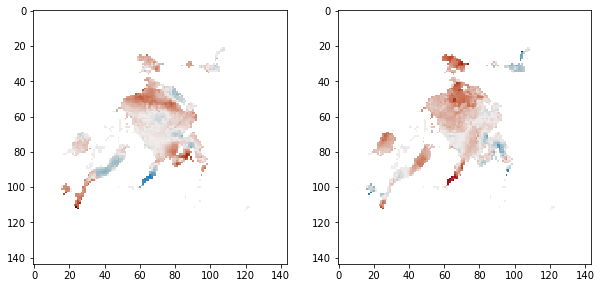

In [17]:
dx_mean = np.nanmean(ddx, axis=0)
dy_mean = np.nanmean(ddy, axis=0)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(dx_mean, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
ax[1].imshow(dy_mean, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
plt.show()


In [18]:
dds['status_flag']

<class 'netCDF4._netCDF4.Variable'>
int8 status_flag(time, yc, xc)
    long_name: rejection and quality level flag
    standard_name: sea_ice_x_displacement status_flag
    valid_min: 0
    valid_max: 30
    grid_mapping: Lambert_Azimuthal_Equal_Area
    coordinates: lat lon
    flag_values: [ 0  1  2  3  4  5 10 11 12 13 20 21 22 23 30]
    flag_meanings: missing_input_data over_land no_ice close_to_coast_or_edge summer_period masked_outside_icedrift processing_failed too_low_correlation not_enough_neighbours filtered_by_neighbours smaller_pattern corrected_by_neighbours interpolated gapfilled_wind_parameter nominal_quality
    flag_descriptions: [' 0 -> missing satellite image data\n', ' 1 -> grid point is over land\n', ' 2 -> grid point is not over sufficient ice\n', ' 3 -> grid point is too close to coast or edge\n', ' 4 -> unreliable vector was removed because in summer period\n', ' 5 -> ice drift from winds masked since value is outside region of icedrift from CMCC\n', ' 10 -> op

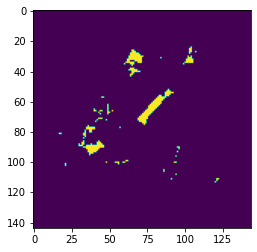

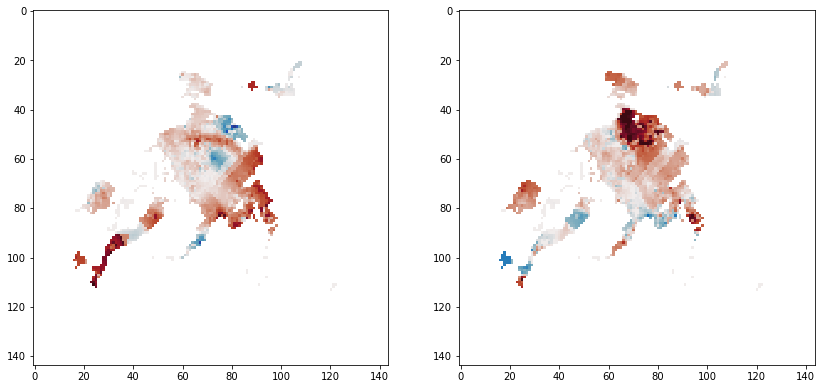

In [19]:
cds = Dataset(sic_files[1])
dds = Dataset(sid_files[1])
sic = cds['ice_conc'][0].filled(np.nan)
dx = dds['dX'][0].filled(np.nan)
dy = dds['dY'][0].filled(np.nan)
dflag = dds['status_flag'][0]

sic_mask = (sic > 0).astype(float)
sic_mask[sic_mask == 0] = np.nan

replace_w_mean = (dflag==22) * (dx == 0) * (dy == 0)
plt.imshow(replace_w_mean)
plt.show()

dxo = np.array(dx)
dyo = np.array(dy)

dx[np.isnan(dx)] = 0
dy[np.isnan(dy)] = 0
dx[replace_w_mean] = np.nan
dy[replace_w_mean] = np.nan
dx = fill_gaps_nn(dx, 100)
dy = fill_gaps_nn(dy, 100)

dx = (dx + dx_mean) / 2
dy = (dy + dy_mean) / 2

dxo[replace_w_mean] = dx[replace_w_mean]
dyo[replace_w_mean] = dy[replace_w_mean]

fig, ax = plt.subplots(1,2, figsize=(14,7))
ax[0].imshow(dxo, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
ax[1].imshow(dyo, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
plt.show()

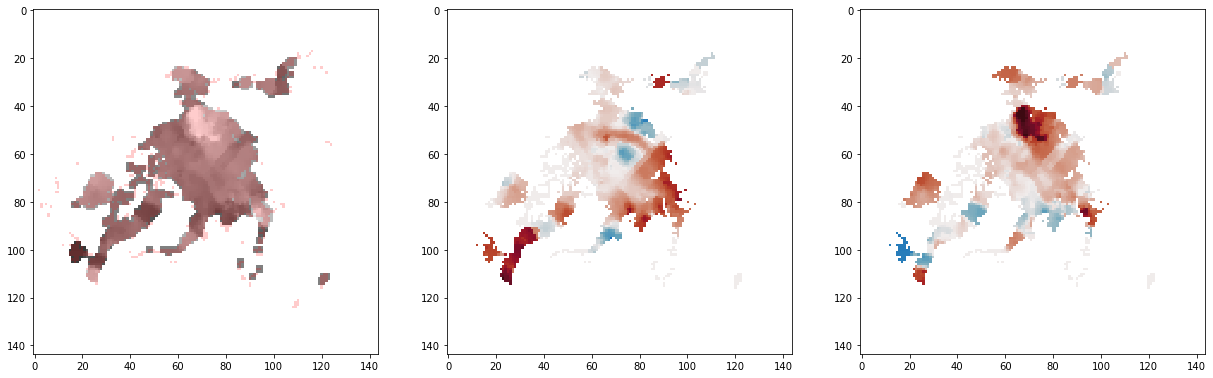

In [20]:
dxof = generic_filter(dxo, np.nanmedian, 3)
dyof = generic_filter(dyo, np.nanmedian, 3)

dxoff = fill_gaps_nn(dxof, 5)
dyoff = fill_gaps_nn(dyof, 5)

dxoff[np.isnan(sic_mask[1:-1:3, 1:-1:3])] = np.nan
dyoff[np.isnan(sic_mask[1:-1:3, 1:-1:3])] = np.nan

fig, ax = plt.subplots(1,3,figsize=(21,7))
ax[0].imshow(dyof, interpolation='nearest', clim=[-20, 20], cmap='gray')
ax[0].imshow(sic_mask[1:-1:3, 1:-1:3], interpolation='nearest', clim=[0,1], cmap='bwr', alpha=0.2)

ax[1].imshow(dxoff, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
ax[2].imshow(dyoff, interpolation='nearest', clim=[-20, 20], cmap=cm.balance)
plt.show()
